# Get Sensors Reading

## Relevant documents

- (Python Client Repo)[https://github.com/Green-Fusion/energy-management-backend/tree/main/python_client]
- (Swagger UI)[https://control.green-fusion.de/services/energy-management-backend/v1/api/doc#/]


## Inits

In [34]:
#imports
from energy_management_client import BackendPythonClient
import pandas as pd
import json
from datetime import datetime,timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [35]:
# select your environment
environment="prod" # prod or dev

# Selector
if environment=="dev":
    backend_endpoint_path="https://dev.green-fusion.de/services/energy-management-backend/v1/api"
    realm_type="development"
elif environment=="prod":
    backend_endpoint_path="https://control.green-fusion.de/services/energy-management-backend/v1/api"
    realm_type="control"  
else:
    backend_endpoint_path=""
    realm_type=""
    print("select either prod or dev for the environment")

#test
#backend_endpoint_path, realm_type
if True:
    # pythpon client auth & login
    # init the client   
    client = BackendPythonClient(backend_endpoint=backend_endpoint_path,)
    
    #login
    client.login(
        auth_endpoint="https://auth.green-fusion.de",
        realm=realm_type,
        client_id="backend_python_client", # backend_python_client, datascience_development_api
        grant_type="device_code", #"client_credentials",  # or "password", "device_code"
    )

In [36]:
# select parameters
building_id=2362  # Bossi Straße gibt es notizen: Temperatur Vorlauf Elektro Kessel: building_id=2362
only_temperature=False
granularity_in_seconds=60 #granularity

x_days = 2  # number of days before now
now = datetime.now()
start_datetime = now - timedelta(days=x_days)
start_time = start_datetime.strftime('%Y-%m-%dT%H:%M:%S')
end_time = now.strftime('%Y-%m-%dT%H:%M:%S')
#start_time='2025-05-15T00:00:00'
#end_time='2025-07-14T23:59:00'

In [41]:
client.buildings.get_building_by_id(1800)

BuildingDto(building_id=1800, customer_id=115, address='Niermannstr. 2', city='Grevenbroich', atvise_display_name=None, base=None, heating_type='Hybrid', heating_surface=5676, access_key='&atvise_key=91e70eae-b284-4fd4-b124-72b76d4f71ed&atvise_token=c1be3026-22ba-4851-b9fa-c5214b3a79f1', modular_system='{"name":"modular-system-entry","id":"modular-system--niermannstr-2-4","version":"v1","buildingID":1800,"published":true,"layoutID":"gas:1--solar-thermal:1--warm-water:1--heating-circuit:1--heating-circuit:2--heating-circuit:3","subSystems":[{"id":"gas:1","name":"gas","hydraulicLocationIndex":1,"parameters":{},"connections":[{"to":{"id":"heating-circuit:3","subSystem":{"name":"heating-circuit","hydraulicLocationIndex":3,"side":"bottom"},"direction":"right"},"status":"hot"},{"from":{"id":"heating-circuit:3","subSystem":{"name":"heating-circuit","hydraulicLocationIndex":3,"side":"bottom"},"direction":"right"},"status":"cold"}],"navigation":{"forward":{"name":"solar-thermal","hydraulicLocat

## Functions

### sensor list for building

In [20]:
def get_sensor_dataframe_by_building_id(building_id, client):
    """
    Fetch sensor data for a given building ID and return it as a pandas DataFrame,
    with sensor ID as the index and relevant metadata as columns.
    
    Parameters:
    - building_id (int): The building ID.
    - client: The API client with the `buildings` attribute.
    
    Returns:
    - pd.DataFrame: DataFrame with sensor metadata.
    """
    sensors = client.buildings.get_list_of_sensors_by_building_id(building_id)
    
    data = []
    for sensor in sensors:
        data.append({
            "sensor_id": sensor.id,
            "unit": sensor.unit,
            "factor": sensor.factor,
            "acronym": sensor.acronym,
            "hydraulic_location_index": sensor.hydraulic_location_index,
            "long_name": sensor.long_name,
            "short_name": sensor.short_name,
            "source":sensor.source
        })
    
    df = pd.DataFrame(data).set_index("sensor_id")
    # Drop rows where unit, long_name, and short_name are all None
    df = df[~(df["unit"].isna() & df["long_name"].isna() & df["short_name"].isna())]
    return df

### Sensors readings

In [21]:
def get_chart_data_with_building_str(sensor_ids, start_time, end_time, granularity_in_seconds, client):
    response = client.charts.data(sensor_ids, start_time, end_time, granularity_in_seconds)
    
    sensor_value_dfs = []
    building_id = None

    for sensor_id_str, datapoints in response.sensors.items():
        if not datapoints:
            continue
        
        if building_id is None:
            building_id = str(datapoints[0].building)  # get building from first datapoint
        
        times = [dp.time for dp in datapoints]
        values = [dp.value for dp in datapoints]

        df_values = pd.DataFrame({
            "timestamp": pd.to_datetime(times),
            sensor_id_str: values
        }).set_index("timestamp")

        sensor_value_dfs.append(df_values)

    df_values_combined = pd.concat(sensor_value_dfs, axis=1).sort_index()

    return df_values_combined
#client.charts.data(sensor_ids,start_time,end_time,granularityInSeconds)

### Sensor infos

## get data

In [22]:
client.buildings.get_list_of_sensors_by_building_id(building_id)

[BuildingSensorDto(id=36256, gf_standard_id=460, sub_system_id=220909, hydraulic_location_index=1, factor=1, current_value=None, node_id='YC', acronym='e_g_bldg_y', unit='kWh', long_name='Energie Gebäude Global Jährlich', short_name='E BLDG GL ', source='MANUALLY_ENTERED'),
 BuildingSensorDto(id=41893, gf_standard_id=None, sub_system_id=None, hydraulic_location_index=1, factor=1, current_value=0, node_id='2', acronym=None, unit=None, long_name=None, short_name=None, source='GREENBOX_MQTT'),
 BuildingSensorDto(id=41892, gf_standard_id=369, sub_system_id=None, hydraulic_location_index=1, factor=0.1, current_value=435, node_id='1', acronym='t_hp(n)_secflow', unit='°C', long_name='Vorlauftemperatur sekundär Wärmepumpe (n)', short_name='T VLsek WP (n)', source='GREENBOX_MQTT'),
 BuildingSensorDto(id=41895, gf_standard_id=None, sub_system_id=None, hydraulic_location_index=1, factor=1, current_value=0, node_id='4', acronym=None, unit=None, long_name=None, short_name=None, source='GREENBOX_MQT

In [24]:
df_sensors_infos = get_sensor_dataframe_by_building_id(building_id, client)
df_sensors_infos.index = df_sensors_infos.index.astype(int)

In [25]:
df_sensors_infos

,unit,factor,acronym,hydraulic_location_index,long_name,short_name,source
sensor_id,,,,,,,
36256,kWh,1.0,e_g_bldg_y,1.0,Energie Gebäude Global Jährlich,E BLDG GL,MANUALLY_ENTERED
41892,°C,0.1,t_hp(n)_secflow,1.0,Vorlauftemperatur sekundär Wärmepumpe (n),T VLsek WP (n),GREENBOX_MQTT
41894,°C,0.1,t_hp(n)_secreturn,1.0,Rücklauftemperatur sekundär Wärmepumpe (n),T RLsek WP (n),GREENBOX_MQTT
41900,°C,0.1,t_hp(n)_secflow,2.0,Vorlauftemperatur sekundär Wärmepumpe (n),T VLsek WP (n),GREENBOX_MQTT
41904,°C,0.1,t_hp(n)_primflow,2.0,Vorlauftemperatur primär Wärmepumpe (n),T VLprim WP (n),GREENBOX_MQTT
41916,°C,0.1,t_buffer(n)_tank_1,1.0,Sensortemperatur 1 Puffer (n),T 1 BT (n),GREENBOX_MQTT
41922,°C,0.1,t_hc(n)_flow,1.0,Vorlauftemperatur Heizkreis (n),T VL HK (n),GREENBOX_MQTT
41926,°C,1.0,t_g_out_api,NaN,Außentemperatur Global,T A GL,OPEN_WEATHER_API
41896,°C,0.1,t_hp(n)_primflow,1.0,Vorlauftemperatur primär Wärmepumpe (n),T VLprim WP (n),GREENBOX_MQTT


In [9]:
#exclude manually entered
df_sensors_infos = df_sensors_infos[df_sensors_infos['source'] != 'MANUALLY_ENTERED']
df_sensors_infos = df_sensors_infos[df_sensors_infos['unit'].notna()]
if only_temperature:
    df_sensors_infos = df_sensors_infos[df_sensors_infos['unit'] == '°C']


In [10]:
df_sensors_infos['unit'].unique()

array(['°C'], dtype=object)

In [11]:
#list(df_sensors.index)

In [12]:
df_sensor_data = get_chart_data_with_building_str(
    sensor_ids=list(df_sensors_infos.index),
    start_time=start_time,
    end_time=end_time,
    granularity_in_seconds=granularity_in_seconds,
    client=client
)
df_sensor_data.columns = df_sensor_data.columns.astype(int)

In [27]:
df_sensor_data.tail(20)

,41892,41894,41896,41898,41900,41902,41904,41906,41908,41910,41912,41914,41916,41922,41924,41926
timestamp,,,,,,,,,,,,,,,,
2025-08-18 11:21:00+00:00,43.9,47.4,32.8,32.9,33.3,34.3,32.3,32.1,47.7,62.8,65.0,57.4,71.2,41.7,28.8,NaN
2025-08-18 11:22:00+00:00,43.9,47.3,32.8,32.8,33.2,34.3,32.3,32.1,47.7,62.9,65.0,57.4,71.3,41.7,28.8,NaN
2025-08-18 11:23:00+00:00,44.0,47.3,32.8,32.9,33.3,34.3,32.3,32.1,47.7,63.0,65.0,57.4,71.2,41.6,28.8,NaN
2025-08-18 11:24:00+00:00,43.9,47.3,32.8,32.9,33.3,34.3,32.3,32.1,47.7,63.1,65.2,57.4,71.3,41.7,28.8,NaN
2025-08-18 11:25:00+00:00,43.9,47.2,32.8,32.8,33.2,34.3,32.3,32.0,47.7,63.3,65.3,57.4,71.3,41.7,28.7,25.35
2025-08-18 11:26:00+00:00,43.9,47.2,32.8,32.8,33.3,34.3,32.3,32.1,47.7,63.5,65.5,57.5,71.3,41.7,28.7,NaN
2025-08-18 11:27:00+00:00,43.8,47.1,32.8,32.7,33.2,34.2,32.2,32.0,47.9,63.6,65.7,57.5,71.3,41.8,28.7,NaN
2025-08-18 11:28:00+00:00,43.9,47.1,32.8,32.8,33.3,34.3,32.3,32.1,47.9,63.7,65.8,57.4,71.3,41.8,28.7,NaN
2025-08-18 11:29:00+00:00,43.8,47.0,32.8,32.8,33.2,34.3,32.3,32.1,48.0,63.9,66.0,57.5,71.3,41.9,28.7,NaN


In [14]:
#df_sensor_data.tail()

## Charts

In [28]:
def plot_sensors(df_sensor_data, df_sensors_infos, html_filename):
    # Get unique units
    units = df_sensors_infos['unit'].unique()
    
    # Sort units: °C first, then kWh, then others
    def unit_sort_key(u):
        if u == '°C':
            return 0
        elif u.lower() == 'kwh':
            return 1
        elif u.lower() == 'm³/h':
            return 2	
        else:
            return 3
    sorted_units = sorted(units, key=unit_sort_key)
    
    n_units = len(sorted_units)
    
    base_height_per_unit = 400
    vertical_spacing = 0.1
    
    fig_height = int(base_height_per_unit * n_units * 1.3)  # increase height by 30%
    fig_width = 1600
    
    fig = make_subplots(
        rows=n_units,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=vertical_spacing,
        subplot_titles=[f"Unit: {unit}" for unit in sorted_units]
    )
    # Show x-axis tick labels on all subplots
    for i in range(1, n_units + 1):
        fig.update_xaxes(showticklabels=True, row=i, col=1)
    
    # Iterate over units with their subplot row index
    for i, unit in enumerate(sorted_units, start=1):
        # Get sensor IDs that belong to this unit
        sensor_ids = df_sensors_infos[df_sensors_infos['unit'] == unit].index
        
        for sensor_id in sensor_ids:
            if sensor_id not in df_sensor_data.columns:
                continue  # no data
            
            y_data = df_sensor_data[sensor_id].dropna()  # filter here
            
            if y_data.empty:
                continue  # skip if no valid data
            
            fig.add_trace(
                go.Scatter(
                    x=y_data.index,    # use filtered index
                    y=y_data,          # use filtered data without NaNs
                    mode='lines',
                    name=f"{sensor_id} {df_sensors_infos.loc[sensor_id, 'acronym']}"
                ),
                row=i,
                col=1
            )
        

        fig.update_xaxes(
            showticklabels=True,
            row=i,
            col=1
        )
    
    fig.update_layout(
        margin=dict(l=60, r=60, t=80, b=60),
    )
    
    fig.write_html(html_filename)
    print(f"Plot saved as {html_filename}")


In [29]:
file_name='sensors_of_building_'+str(building_id)+'_'+start_time[:10]+'_'+end_time[:10]+'.html'
plot_sensors(df_sensor_data, df_sensors_infos, file_name)

Plot saved as sensors_of_building_2362_2025-08-16_2025-08-18.html


<Axes: xlabel='timestamp'>

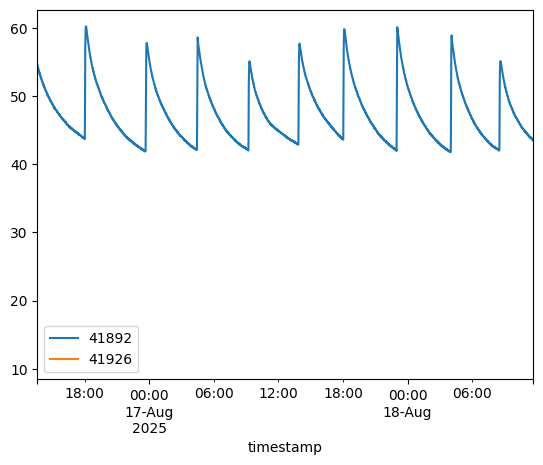

In [32]:
df_sensor_data[[41892,41926]].plot()